In [41]:
import meep as mp
import meep.adjoint as mpa
import numpy as np
import nlopt
from autograd import numpy as npa
from autograd import tensor_jacobian_product, grad
from matplotlib import pyplot as plt
import os
import math

mp.verbosity(1)

Lpml = 0.5
SiO2 = mp.Medium(index=1.5*1.5)
pml_layers = [mp.PML(thickness = Lpml,)]
resolution = 100


# Constants
PI = np.pi

import math


diameter = 1
scale_down = 1.0  # scale down factor
A = 1.0  # 1A = 500nm(0.5), 1um(1.0)
NA = 0.5  # Numerical Aperture
d = (diameter / scale_down) / 2   # (diameter / scale_down) / 2 -> half of the diameter // fixed
et = d/4
focal = d / NA
focal_length = math.sqrt(focal ** 2 - d ** 2)
r_cur = focal / (2 * A * scale_down)
src_ypos = (d+Lpml)*2 - Lpml  # source position in z direction
lens_ypos = src_ypos - d/2  # lens position in z direction
x_center = 0.0  # r center position of the circle
y_center = lens_ypos - math.sqrt(r_cur ** 2 - d ** 2)

# source 설정
width = 0.1

fcen_red = 1/(0.65)
fwidth_red = fcen_red * width

fcen_green = 1/(0.55)
fwidth_green = fcen_green * width

fcen_blue = 1/(0.45)
fwidth_blue = fcen_blue * width

src_0 = mp.GaussianSource(frequency=fcen_red, fwidth=fwidth_red, is_integrated=True)

src_1 = mp.GaussianSource(frequency=fcen_green, fwidth=fwidth_green, is_integrated=True)

src_2 = mp.GaussianSource(frequency=fcen_blue, fwidth=fwidth_blue, is_integrated=True)

source_center = [0, (d+Lpml)*2 - Lpml - 0.5] # Source 위치
source_size = mp.Vector3(d*2)

source = [mp.Source(src_0, component=mp.Ez, size=source_size, center=source_center,)]


print(focal)
print(y_center)
print(lens_ypos)
print(r_cur)

1.0
1.25
1.25
0.5


     block, center = (-0.49,0.26,0)
          size (0.005,0.005,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (5.0625,5.0625,5.0625)
     block, center = (-0.49,0.27,0)
          size (0.005,0.005,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (5.0625,5.0625,5.0625)
     block, center = (-0.49,0.28,0)
          size (0.005,0.005,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (5.0625,5.0625,5.0625)
     block, center = (-0.49,0.29,0)
          size (0.005,0.005,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (5.0625,5.0625,5.0625)
     block, center = (-0.49,0.3,0)
          size (0.005,0.005,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (5.0625,5.0625,5.0625)
     block, center = (-0.49,0.31,0)
          size (0.005,0.005,0)
          axes (1,0,0), (0,1,0), (

<Axes: xlabel='X', ylabel='Y'>

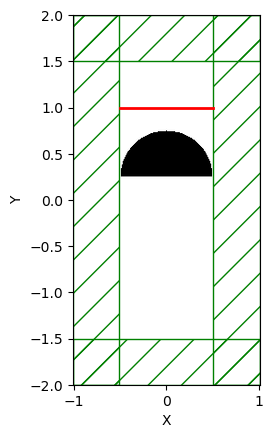

In [42]:
cell = mp.Vector3((d+Lpml)*2+2/resolution, (d+Lpml)*4)
# cell = mp.Vector3(10, 10)

geometry = [
    # mp.Block(
    #     center=mp.Vector3(y=lens_ypos-et/2), size=mp.Vector3(d*2,et), material=SiO2
    # )
]
for pos_x in np.arange(-10, 10, 0.01):
    for pos_y in np.arange(-10, 10, 0.01):
        if pos_y>=(lens_ypos):
            if ((pos_x-x_center)*(pos_x-x_center) + (pos_y-y_center)*(pos_y-y_center) <= (r_cur*r_cur)):
                geometry.append(mp.Block(center=mp.Vector3(pos_x , pos_y-1), size=mp.Vector3(0.5/resolution, 0.5/resolution), material=SiO2))
    

            
            
sim = mp.Simulation(
    cell_size=cell, 
    boundary_layers=pml_layers,
    geometry=geometry,
    sources=source,
    resolution=resolution,
)
sim.plot2D()

In [43]:
tran_total0 = sim.add_dft_fields([mp.Ez], fcen_red, 0 , 1, center=mp.Vector3(0, 0, 0), size=mp.Vector3(diameter, diameter*2), yee_grid=True)

pt = mp.Vector3(0,lens_ypos-focal,0)

sim.run(until_after_sources=mp.stop_when_fields_decayed(50, mp.Ez, pt, 1e-9)) 


-----------
Initializing structure...
time for choose_chunkdivision = 0.0127749 s
Working in 2D dimensions.
Computational cell is 2.02 x 4 x 0 with resolution 100
     block, center = (-0.49,0.26,0)
          size (0.005,0.005,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (5.0625,5.0625,5.0625)
     block, center = (-0.49,0.27,0)
          size (0.005,0.005,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (5.0625,5.0625,5.0625)
     block, center = (-0.49,0.28,0)
          size (0.005,0.005,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (5.0625,5.0625,5.0625)
     block, center = (-0.49,0.29,0)
          size (0.005,0.005,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (5.0625,5.0625,5.0625)
     block, center = (-0.49,0.3,0)
          size (0.005,0.005,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          

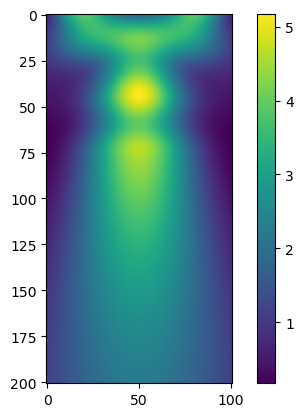

In [45]:
total_flux0 = np.abs(sim.get_dft_array(tran_total0, mp.Ez, 0))**2


plt.imshow(npa.rot90(total_flux0.reshape(diameter* resolution+1, diameter*2* resolution+1)))
plt.colorbar()

In [17]:
sim.reset_meep()